## Emojifier using LSTM

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.initializers import glorot_uniform
np.random.seed(42)

### Get training and testing data

In [2]:
def parse_csv():
    csvv = pd.read_csv('./dataset/train_emoji.csv', delimiter=',', names=['X_train', 'Y_train', '.', '..'])
    csvv.drop(['.', '..'], axis=1, inplace=True)
    X_train = csvv.X_train
    Y_train = csvv.Y_train

    csvv = pd.read_csv('./dataset/test_emoji.csv', delimiter=',', names=['X_test', 'Y_test', '.', '..'])
    csvv.drop(['.', '..'], axis=1, inplace=True)
    X_test = csvv.X_test
    Y_test = csvv.Y_test
    
    return X_train, Y_train, X_test, Y_test

In [3]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.values.reshape(-1)]
    return Y

### Make the embedding using Glove vector

In [4]:
def get_embeddings(filename):
    with open(filename) as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

In [5]:
words_to_index, index_to_words, word_to_vec_map = get_embeddings('../../datasets/glove.6B.50d.txt')

### Pads and converts words into indices for later to be used as input to the embedding layer
not sure why

In [6]:
def sentences_to_indices(X, words_to_index, max_len):
    m = X.shape[0]
    X_indices = np.zeros((m, max_len))
    for i in range(m):
        sentence_words = X[i].lower().split()
        j = 0
        for w in sentence_words:
            X_indices[i][j] = words_to_index[w]
            j += 1
            if j >= max_len:
                break
    return X_indices

In [7]:
X1 = np.array(["1", "funny lol", "lets play baseball", "food is ready for you"])
X1_indices = sentences_to_indices(X1, words_to_index, max_len=5)
print("X1 =", X1)
print("X1_indices =\n", X1_indices)

X1 = ['1' 'funny lol' 'lets play baseball' 'food is ready for you']
X1_indices =
 [[  2479.      0.      0.      0.      0.]
 [155345. 225122.      0.      0.      0.]
 [220930. 286375.  69714.      0.      0.]
 [151204. 192973. 302254. 151349. 394475.]]


In [8]:
X_train, Y_train, X_test, Y_test = parse_csv()
sentences_to_indices(X_train, words_to_index=words_to_index, max_len=10)

array([[259914., 352214., 360915., ...,      0.,      0.,      0.],
       [185457.,  52943., 293982., ...,      0.,      0.,      0.],
       [193716., 192973., 357266., ..., 222138.,      0.,      0.],
       ...,
       [386307., 192973., 390470., ...,      0.,      0.,      0.],
       [185457., 226278., 394475., ...,      0.,      0.,      0.],
       [166369., 198213.,      0., ...,      0.,      0.,      0.]])

### Initializing Pretrained Embedding Layer

In [9]:
def pretrained_embedding_layer():
    vocab_size = len(words_to_index) + 1              
    any_word = list(word_to_vec_map.keys())[0]
    emb_dim = word_to_vec_map[any_word].shape[0]    # define dimensionality of your GloVe word vectors (= 50)

    emb_matrix = np.zeros([vocab_size,emb_dim])
    
    for word, idx in words_to_index.items():
        emb_matrix[idx, :] = word_to_vec_map[word]

    embedding_layer = Embedding(vocab_size, emb_dim ,trainable = False)

    embedding_layer.build((None,))
  
    embedding_layer.set_weights([emb_matrix])
    return embedding_layer


### Build the model

In [10]:
def emoji_model(input_shape):
    sentence_indices = Input(shape=input_shape, dtype='int32')
    embedding_layer = pretrained_embedding_layer()
    embeddings = embedding_layer(sentence_indices)
    X = LSTM(units=128, return_sequences=True)(embeddings)
    X = Dropout(0.5)(X)
    X = LSTM(units=128,return_sequences = False)(X)
    X = Dropout(0.5)(X)
    X = Dense(5)(X)
    X = Activation('softmax')(X)
    model = Model(inputs=sentence_indices,outputs=X)
    return model

In [11]:
max_len = 10
new_model = emoji_model((max_len, ))
new_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 10, 50)         │    20,000,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 10, 128)        │        91,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           645 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 5)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,223,927 (77.15 MB)

 Trainable params: 20,223,927 (77.15 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
new_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


X_train_indices = sentences_to_indices(X_train, words_to_index, max_len)
Y_train_oh = convert_to_one_hot(Y_train, C=5)

history = new_model.fit(X_train_indices, Y_train_oh, epochs=100, batch_size=32, shuffle=True)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.2681 - loss: 1.5858
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.3260 - loss: 1.5244
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.4246 - loss: 1.4444
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.4016 - loss: 1.3886
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.5328 - loss: 1.2608
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.5781 - loss: 1.1261
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.6225 - loss: 0.9853
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.6759 - loss: 0.7945
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.7959 - loss: 0.6826
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8183 - loss: 0.5803
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.7916 - loss: 0.5720
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8587 - lo

### Plot the learning curve

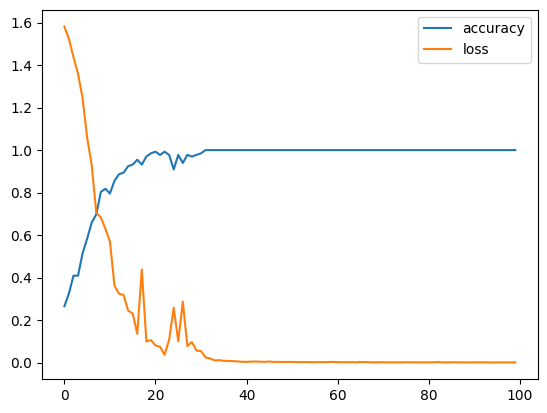

In [13]:
lc = pd.DataFrame(history.history).plot().figsize=(10, 10)